## 3. Model Selection and Justification
In this section, we experiment with multiple machine learning algorithms
to predict wine quality (good vs not good). We will use cross-validation
and hyperparameter tuning to compare model performance.
### Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score, ConfusionMatrixDisplay, RocCurveDisplay, precision_recall_curve, \
    roc_auc_score
from sklearn.model_selection import RandomizedSearchCV

%matplotlib inline
sns.set(style='whitegrid', font_scale=1.1)


### Load preprocessor and train/test split from previous notebook

In [3]:
print('Loading saved artifacts...')
art = joblib.load('train_test_data.pkl')
X_train, X_test = art['X_train'], art['X_test']
y_train, y_test = art['y_train'], art['y_test']

preprocessor = joblib.load('preprocessor.pkl')

print(f'Loaded: X_train={X_train.shape}, X_test={X_test.shape}, y_train={y_train.shape}, y_test={y_test.shape}')

Loading saved artifacts...
Loaded: X_train=(5197, 13), X_test=(1300, 13), y_train=(5197,), y_test=(1300,)


This matches the data we had in Step 2 after preprocessing and splitting, so the import is correct.

### Class balance check (important to choose metrics and sampling strategies)

In [4]:
print('\nClass distribution (train):')
print(y_train.value_counts(normalize=True))


Class distribution (train):
quality_label
0    0.803541
1    0.196459
Name: proportion, dtype: float64


"Not good" wines (quality < 7) ~80%, "Good" wines (quality >= 7) ~20%. This means our dataset is imbalanced, about 4:1 ratio.
This imbalance affects our choice of evaluation metrics.
Accuracy would be misleading (a model predicting all wines as “not good” would still get 80% accuracy).

Instead, we will focus on F1 score, as well as ROC-AUC.
This size of imbalance usually does not require resampling, so we will use class_weight='balanced' in our models to adjust for it.


### Define Models

Our target variable is wine quality, originally on an integer scale of 0-10. We chose to convert this into a binary classification problem of "good" (quality >= 7) vs "not good" (quality < 7).
This means our primary task is binary classification. We chose the following models to compare:

Logistic Regression (Baseline):
Chosen as a simple, interpretable baseline for binary classification. Reference point for more complex models. Due to its linearity, it will struggle with the nonlinear relationships in the data.

Random Forest Classifier:
Tree-based ensemble model that excels at modeling nonlinear relationships and feature interactions. Resistant to outliers and noise. Seems well suited to our dataset, however its main weakness is overfitting when to many deep trees are used. Cross fitting and hyperparameter tuning can help reduce this.

Gradient Boosting Classifier:
Can achieve higher predictive accuracy than single trees or Random Forest.
Can reveal subtle nonlinear patterns between features and target.
We can compare this to Random Forest to compare bagging vs boosting performance.
However, it is more sensitive to noise and hyperparameters.

Support Vector Classifier (SVC, RBF kernel):
Captures complex, nonlinear decision boundaries.
Provides a non-tree comparison to ensemble methods.
Useful for testing whether the separation between classes is linear or nonlinear.
However, it scales poorly with data size.

In [5]:
models = {
    'LogisticRegression': LogisticRegression(max_iter=2000, class_weight='balanced', solver='liblinear'),
    'RandomForest': RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'SVC': SVC(kernel='rbf', class_weight='balanced', probability=True)
}

Note:
GradientBoosting does not support class_weight. Given the moderate imbalance (80/20) and the use of F1 and ROC-AUC metrics, class weighting is not required. The model still performs comparably to the others.

### Cross-Validation

LogisticRegression: F1 = 0.525 ± 0.025 | ROC-AUC = 0.802 ± 0.023
RandomForest: F1 = 0.603 ± 0.025 | ROC-AUC = 0.900 ± 0.013
GradientBoosting: F1 = 0.463 ± 0.037 | ROC-AUC = 0.856 ± 0.017
SVC: F1 = 0.567 ± 0.015 | ROC-AUC = 0.851 ± 0.013


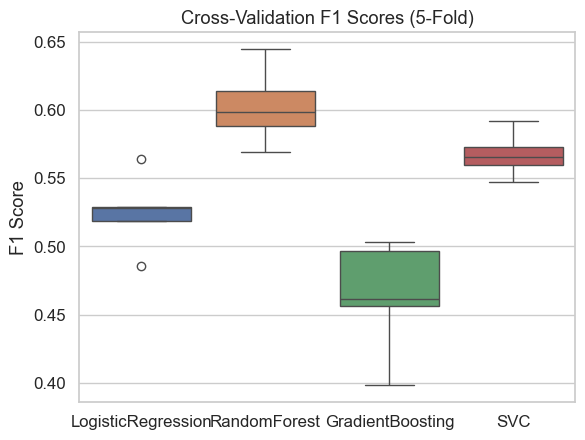

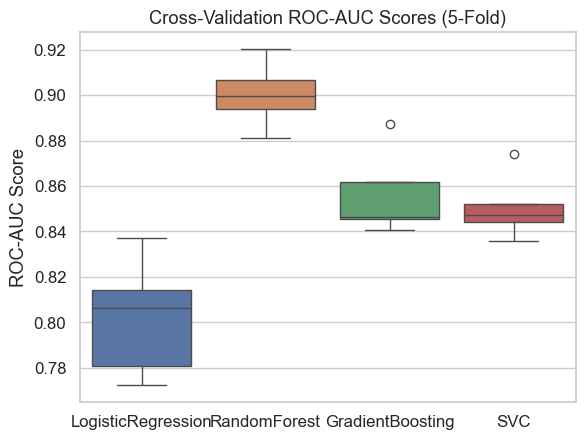

In [6]:
# Stratified K-Fold keeps class ratios across folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Dictionaries to store CV results
cv_f1_results = {}
cv_auc_results = {}

for name, model in models.items():
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("classifier", model)
    ])

    # F1 scores
    f1_scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='f1', n_jobs=-1)
    cv_f1_results[name] = f1_scores

    # ROC-AUC scores
    auc_scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
    cv_auc_results[name] = auc_scores

    print(
        f"{name}: F1 = {f1_scores.mean():.3f} ± {f1_scores.std():.3f} | ROC-AUC = {auc_scores.mean():.3f} ± {auc_scores.std():.3f}")

# Convert to DataFrame for plotting
f1_df = pd.DataFrame(cv_f1_results)
sns.boxplot(data=f1_df)
plt.title("Cross-Validation F1 Scores (5-Fold)")
plt.ylabel("F1 Score")
plt.show()

auc_df = pd.DataFrame(cv_auc_results)
sns.boxplot(data=auc_df)
plt.title("Cross-Validation ROC-AUC Scores (5-Fold)")
plt.ylabel("ROC-AUC Score")
plt.show()

Random Forest is the best starting point for hyperparameter tuning (Best performer on both F1 and ROC-AUC).

Gradient Boosting (Low F1, Decent ROC-AUC): Might improve with learning rate, n_estimators, and max_depth adjustments.

SVC (Good, slightly worse than Random Forest): can improve with C and gamma tuning.

Logistic Regression serves as a baseline. Interpretable, but middling performance.

### Hyperparameter Tuning

### Since our dataset isn’t huge (~6.5k rows), we use RandomizedSearchCV (faster than GridSearchCV) with stratified CV:
Random Forest:
- n_estimators: Number of trees in the forest.
More trees can improve performance by reducing variance, but too many increases computation time.

- max_depth: Maximum depth of each tree.
Controls model complexity. Shallow trees prevent overfitting, while deeper trees capture more patterns.

- min_samples_split: Minimum number of samples required to split an internal node.
Higher values prevent splits on small sample sizes, reducing overfitting.

- min_samples_leaf: Minimum samples required at a leaf node.
Ensures leaves aren’t too small; helps with generalization.

- max_features: Number of features considered for splitting at each node.
Controls randomness in trees; smaller values reduce correlation between trees, improving ensemble performance.

In [7]:
rf = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)

rf_params = {
    'classifier__n_estimators': [100, 200, 500],
    'classifier__max_depth': [None, 5, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['sqrt', 'log2', None]
}

rf_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", rf)
])

scoring = {
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

rf_search = RandomizedSearchCV(
    rf_pipe,
    param_distributions=rf_params,
    n_iter=20,
    cv=cv,
    scoring=scoring,
    refit='f1',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

rf_search.fit(X_train, y_train)

print("Random Forest Best F1 (CV):", rf_search.best_score_)
print("Best ROC-AUC (mean):", rf_search.cv_results_['mean_test_roc_auc'][rf_search.best_index_])
print("Random Forest Best Params:", rf_search.best_params_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Random Forest Best F1 (CV): 0.6478235513602003
Best ROC-AUC (mean): 0.893989270331811
Random Forest Best Params: {'classifier__n_estimators': 500, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 4, 'classifier__max_features': 'sqrt', 'classifier__max_depth': 20}


Gradient Boosting:
- n_estimators: Number of boosting stages (trees).
More stages can improve accuracy.

- learning_rate: Step size for each tree added.
Lower values make learning slower and more robust, while higher values speed up training.

- max_depth: Depth of each tree.
Controls complexity. Shallow trees prevent overfitting; deeper trees capture more interactions.

- min_samples_split & min_samples_leaf: Same reasoning as in Random Forest.
Avoids creating splits or leaves with too few samples, improving generalization.

Note: Gradient Boosting is more sensitive to these parameters because it builds trees sequentially, so overfitting can happen quickly with large/deep trees or high learning rates.

In [8]:
gb = GradientBoostingClassifier(random_state=42)

gb_params = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'classifier__max_depth': [3, 5, 7],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

gb_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", gb)
])

scoring = {
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

gb_search = RandomizedSearchCV(
    gb_pipe,
    param_distributions=gb_params,
    n_iter=20,
    cv=cv,
    scoring=scoring,
    refit='f1',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

gb_search.fit(X_train, y_train)

print("Gradient Boosting Best F1 (CV):", gb_search.best_score_)
print("Best ROC-AUC (mean):", rf_search.cv_results_['mean_test_roc_auc'][rf_search.best_index_])
print("Gradient Boosting Best Params:", gb_search.best_params_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Gradient Boosting Best F1 (CV): 0.6101695643302427
Best ROC-AUC (mean): 0.893989270331811
Gradient Boosting Best Params: {'classifier__n_estimators': 200, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 2, 'classifier__max_depth': 7, 'classifier__learning_rate': 0.1}


SVC Tuning:
- C: Regularization parameter.
Controls the trade-off between maximizing the margin and minimizing classification error.

Low C → wider margin, more regularization (underfitting possible).

High C → smaller margin, allows fewer misclassifications (risk of overfitting).

- gamma: Kernel coefficient for RBF kernel.
Determines influence of a single training point.

Low gamma → far-reaching influence, smoother decision boundary.

High gamma → close influence, can overfit to training data.

In [9]:
svc = SVC(kernel='rbf', class_weight='balanced', probability=True)

svc_params = {
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__gamma': ['scale', 'auto', 0.01, 0.1, 1]
}

svc_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", svc)
])

scoring = {
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

svc_search = RandomizedSearchCV(
    svc_pipe,
    param_distributions=svc_params,
    n_iter=15,
    cv=cv,
    scoring=scoring,
    refit='f1',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

svc_search.fit(X_train, y_train)

print("SVC Best F1 (CV):", svc_search.best_score_)
print("Best ROC-AUC (mean):", svc_search.cv_results_['mean_test_roc_auc'][svc_search.best_index_])
print("SVC Best Params:", svc_search.best_params_)


Fitting 5 folds for each of 15 candidates, totalling 75 fits
SVC Best F1 (CV): 0.6041214473619408
Best ROC-AUC (mean): 0.8690678653059564
SVC Best Params: {'classifier__gamma': 1, 'classifier__C': 1}


### Model Comparison to un-tuned models

,Model,F1 (Untuned),ROC-AUC (Untuned),F1 (Tuned),ROC-AUC (Tuned)
0,Random Forest,0.603,0.900,0.647824,0.893989
1,Gradient Boosting,0.463,0.856,0.610170,0.890067
2,SVC,0.567,0.851,0.604121,0.869068


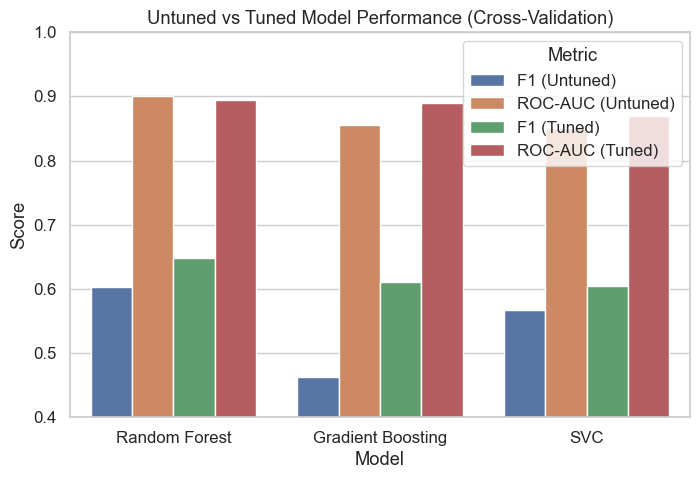

In [10]:
# Un-tuned CV results from earlier model comparison
untuned_results = {
    'Logistic Regression': {'F1 (Untuned)': 0.525, 'ROC-AUC (Untuned)': 0.802},
    'Random Forest': {'F1 (Untuned)': 0.603, 'ROC-AUC (Untuned)': 0.900},
    'Gradient Boosting': {'F1 (Untuned)': 0.463, 'ROC-AUC (Untuned)': 0.856},
    'SVC': {'F1 (Untuned)': 0.567, 'ROC-AUC (Untuned)': 0.851}
}

# Tuned model searches
searches = {
    'Random Forest': rf_search,
    'Gradient Boosting': gb_search,
    'SVC': svc_search
}

summary_rows = []

for name, search in searches.items():
    f1_cv = search.best_score_
    roc_cv = search.cv_results_['mean_test_roc_auc'][search.best_index_]

    summary_rows.append({
        'Model': name,
        'F1 (Untuned)': untuned_results[name]['F1 (Untuned)'],
        'ROC-AUC (Untuned)': untuned_results[name]['ROC-AUC (Untuned)'],
        'F1 (Tuned)': f1_cv,
        'ROC-AUC (Tuned)': roc_cv
    })

# Display results
results_all = pd.DataFrame(summary_rows).sort_values(by='F1 (Tuned)', ascending=False)
display(results_all)

# Plot comparison
results_melted = results_all.melt(id_vars='Model', var_name='Metric', value_name='Score')

plt.figure(figsize=(8,5))
sns.barplot(data=results_melted, x='Model', y='Score', hue='Metric')
plt.title('Untuned vs Tuned Model Performance (Cross-Validation)')
plt.ylim(0.4, 1)
plt.show()


### Conclusions
- After tuning, all F1 scores improved significantly.
- Gradient Boosting shows the largest F1 increase but still scored worse than Random Forest.
- The ROC-AUC score for both Gradient Boosting and SVC improved slightly, but did not pass the tuned Random Forest ROC-AUC (very close).
- Random Forest improved further in F1 Score, at the cost of a slight ROC-AUC decrease.

### Test Set Evaluation

,Model,Test F1,Test ROC-AUC
0,Random Forest,0.658683,0.901382
2,SVC,0.649402,0.889016
1,Gradient Boosting,0.644295,0.900103


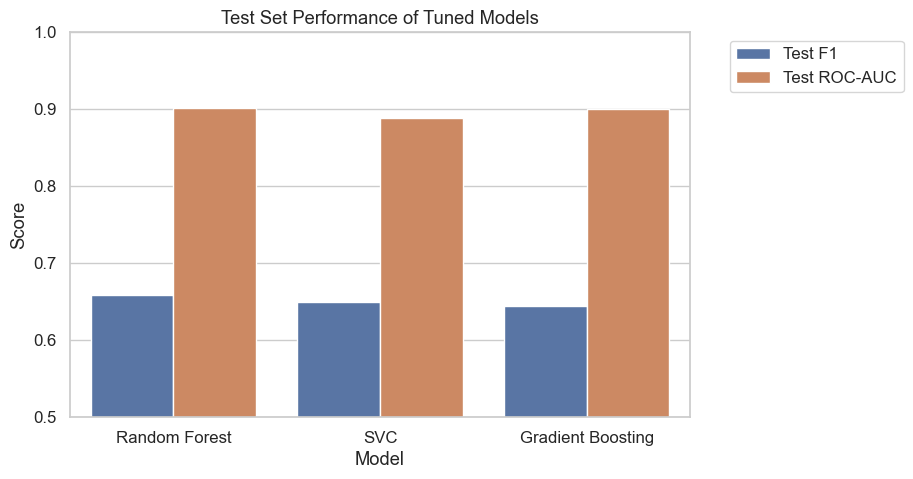

In [11]:
# Evaluate all tuned models on the test set
searches = {
    'Random Forest': rf_search,
    'Gradient Boosting': gb_search,
    'SVC': svc_search
}

summary_rows = []

for name, search in searches.items():
    best_model = search.best_estimator_

    # Predictions
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1]

    # Test metrics
    f1_test = f1_score(y_test, y_pred)
    roc_test = roc_auc_score(y_test, y_proba)

    summary_rows.append({
        'Model': name,
        'Test F1': f1_test,
        'Test ROC-AUC': roc_test
    })

# Display results sorted by Test F1
results_all = pd.DataFrame(summary_rows).sort_values(by='Test F1', ascending=False)
display(results_all)

# Plot test set performance
plt.figure(figsize=(8,5))
results_melted = results_all.melt(id_vars='Model', var_name='Metric', value_name='Score')

sns.barplot(data=results_melted, x='Model', y='Score', hue='Metric')
plt.title('Test Set Performance of Tuned Models')
plt.ylim(0.5, 1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Very similar performance among all three tuned models on the test set, compared to the cross-validation results.
This is a common effect: CV estimates are slightly conservative, while the test set can show small “re-ranking” due to natural sample variability.

### Confusion Matrices and ROC Curves for Tuned Models



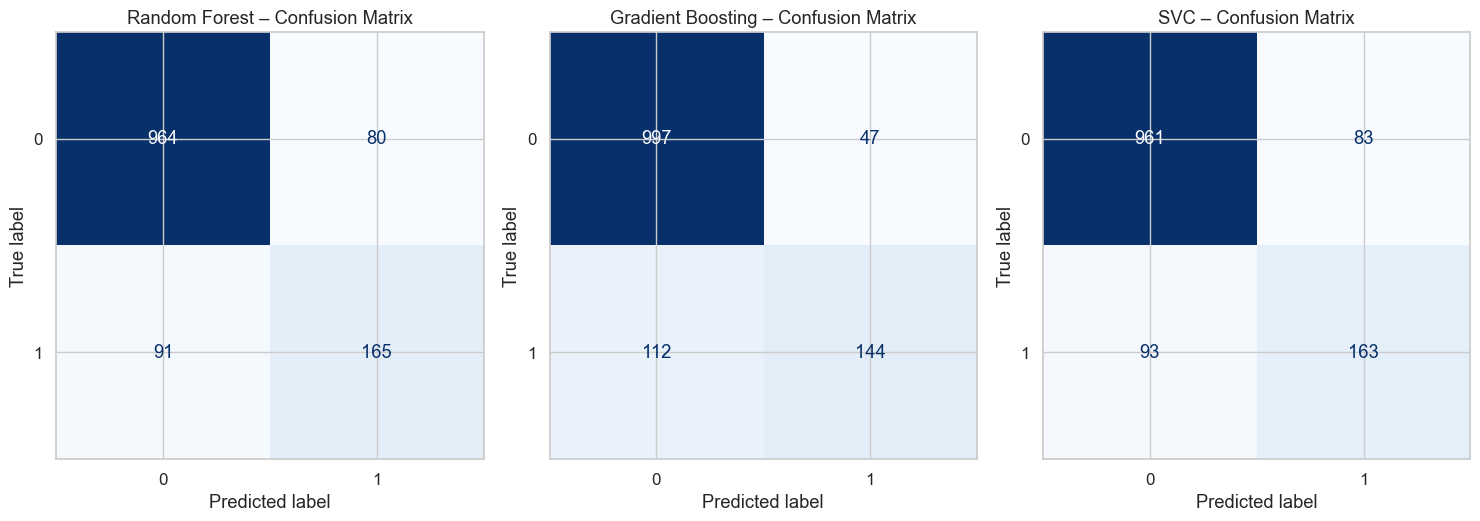

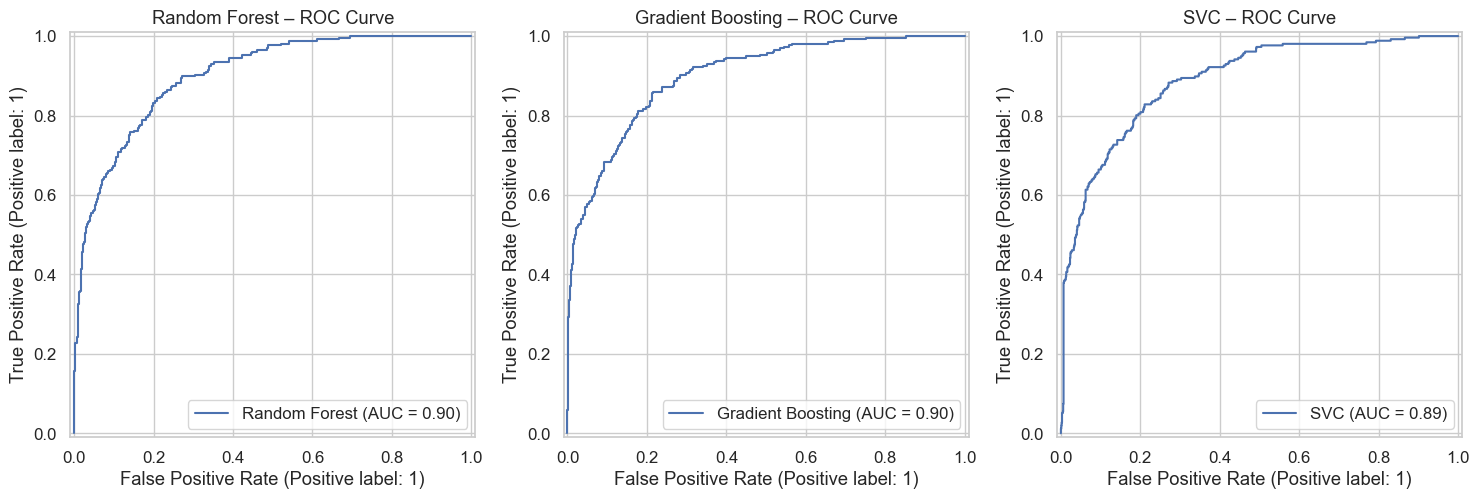

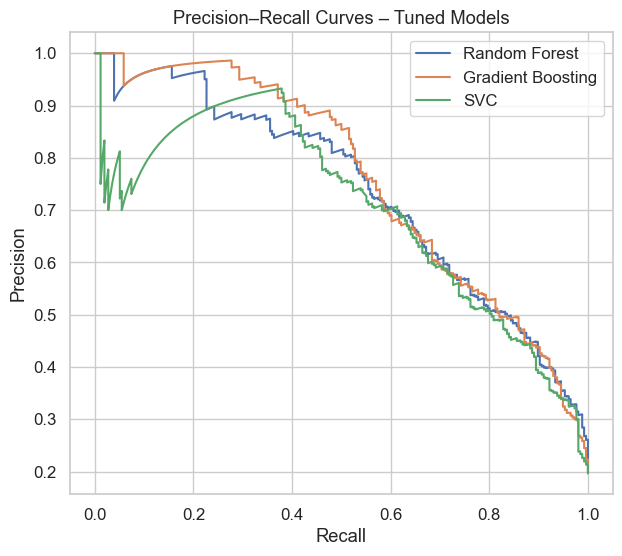

In [16]:
# Models to visualize
final_models = {
    "Random Forest": rf_search.best_estimator_,
    "Gradient Boosting": gb_search.best_estimator_,
    "SVC": svc_search.best_estimator_
}

# Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for ax, (name, model) in zip(axes, final_models.items()):
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, ax=ax, cmap="Blues", colorbar=False)
    ax.set_title(f"{name} – Confusion Matrix")
plt.tight_layout()
plt.show()

# ROC Curves
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for ax, (name, model) in zip(axes, final_models.items()):
    RocCurveDisplay.from_estimator(model, X_test, y_test, ax=ax, name=name)
    ax.set_title(f"{name} – ROC Curve")
plt.tight_layout()
plt.show()

# Optional: Precision–Recall Curves
plt.figure(figsize=(7,6))
for name, model in final_models.items():
    y_proba = model.predict_proba(X_test)[:, 1]
    prec, rec, _ = precision_recall_curve(y_test, y_proba)
    plt.plot(rec, prec, label=name)
plt.title("Precision–Recall Curves – Tuned Models")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

- Random Forest detects most good wines (165/256 = 64.4% recall) while keeping false positives relatively low.
- Gradient Boosting has more false negatives, but very low false positive rate.
- SVC performs similarly to Random Forest, with slightly lower recall, It's a more complex model, but doesn't outperform Random Forest here.


### Model Justification

**Final Model Selection: Random Forest**
- Achieved the highest F1 score (0.648), effectively handling the moderate class imbalance.
- Strong ROC-AUC (0.894) indicates very good class separation and reliable generalization.
- Robust to noise and outliers, requires minimal preprocessing, and provides interpretable feature importances.
- Consistently strong across metrics, offering a stable and practical solution for predicting wine quality.

In [14]:
# Save the tuned pipeline with preprocessing
joblib.dump(rf_search.best_estimator_, "random_forest_model.pkl")

['random_forest_model.pkl']